In [2]:
import csv
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

**1) We want to make categories for the apartments: ​ Really cheap (cheaper than one
standard deviation of the price distribution ─we assume it Normal─ to the lower side), ​ Cheap
(between the really cheap ones and the average price), ​ Expensive (between the average
and one standard deviation to higher side), and ​ Really expensive ​ (more than one standard
deviation to the higher side). How many apartments have each category?**

The first step is to read the data and store it in a dataframe. We then select only those fields which will be used as features for the classification method in another dataframe, called "data".

In [3]:
myairbnbs = pd.read_csv("listings.csv")
data = myairbnbs[["price","neighbourhood_group", "neighbourhood", "latitude", "longitude", "room_type", "minimum_nights",
"number_of_reviews", "reviews_per_month", "availability_365"]]

We see that some values in the column "reviews_per_month" are not available. This would pose a problem later on the analysis, so we replace those NaN values with the value 0.

In [4]:
data["reviews_per_month"]

0        0.02
1        0.25
2        0.48
3        2.38
4        1.71
         ... 
20423     NaN
20424     NaN
20425     NaN
20426     NaN
20427     NaN
Name: reviews_per_month, Length: 20428, dtype: float64

In [5]:
data["reviews_per_month"] = data["reviews_per_month"].fillna(0)
data["reviews_per_month"]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        0.02
1        0.25
2        0.48
3        2.38
4        1.71
         ... 
20423    0.00
20424    0.00
20425    0.00
20426    0.00
20427    0.00
Name: reviews_per_month, Length: 20428, dtype: float64

Since some of the variables are categorical, we can't directly use them on decision trees. We use one-hot encoding (dummy variables) to be able to use this variables.

In [6]:
processed_data = pd.get_dummies(data)
processed_data

,price,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,availability_365,neighbourhood_group_Ciutat Vella,neighbourhood_group_Eixample,neighbourhood_group_Gràcia,...,neighbourhood_la Verneda i la Pau,neighbourhood_la Vila Olímpica del Poblenou,neighbourhood_la Vila de Gràcia,neighbourhood_les Corts,neighbourhood_les Roquetes,neighbourhood_les Tres Torres,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,130,41.40889,2.18555,3,1,0.02,304,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,60,41.40420,2.17306,1,20,0.25,312,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,210,41.41203,2.22114,3,51,0.48,359,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,32,41.40145,2.15645,1,268,2.38,46,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,60,41.40950,2.15938,1,182,1.71,324,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20423,50,41.41177,2.16373,32,0,0.00,349,0,0,0,...,0,0,0,0,0,0,1,0,0,0
20424,508,41.38576,2.17438,3,0,0.00,362,1,0,0,...,0,0,0,0,0,0,1,0,0,0
20425,1031,41.40758,2.17242,3,0,0.00,362,0,1,0,...,0,0,0,0,0,0,1,0,0,0
20426,89,41.39138,2.18240,3,0,0.00,22,1,0,0,...,0,0,0,0,0,0,1,0,0,0


Now to get the labels. We divide the price range as stated in the exercise and make a list with the label corresponding to each apartment.

In [7]:
prices = processed_data["price"]
sdev_price = prices.std()
mean_price = prices.mean()
price_categories = []
for price in prices:
    if price == mean_price:
        price_categories.append("Average")
    elif price < (mean_price - sdev_price):
        price_categories.append("Really Cheap")
    elif price < mean_price and price >= (mean_price - sdev_price):
        price_categories.append("Cheap")
    elif price > mean_price and price <= (mean_price + sdev_price):
        price_categories.append("Expensive")
    else:
        price_categories.append("Really Expensive")
for tipo in set(price_categories):
    print(tipo+": "+str(price_categories.count(tipo)))

Cheap: 16747
Really Expensive: 374
Expensive: 3307


In [8]:
print("%.2f, %.2f"%(sdev_price, mean_price))

478.97, 134.59


One of the categories is not present. That is because the standard deviation is much higher than the mean, so the category "really cheap", which should be composed by those apartments which are further down than one standard deviation from the mean, doesn't even show.

This is explained because there are some really expensive apartments which have a high impact on the standard deviation

**2) We want to know what feature defines better the price between the following features:
neighbourhood_group, neighbourhood, latitude, longitude, room_type, minimum_nights,
number_of_reviews, reviews_per_month, availability_365.
Make a Decision Tree Classifier, plot the resulting decision tree and draw your conclusions.**

We just fit the decision tree to the processed data without the price column, then plot the tree with a depth of 1, to see the most important variables, which should be those in the upper nodes.

In [9]:
training_data = processed_data.drop('price', axis=1)
dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(training_data, price_categories)

[Text(1116.0, 1902.6000000000001, 'X[89] <= 0.5\ngini = 0.301\nsamples = 20428\nvalue = [16747, 3307, 374]'),
 Text(558.0, 1359.0, 'X[2] <= 14.5\ngini = 0.467\nsamples = 10041\nvalue = [6672, 3025, 344]'),
 Text(279.0, 815.4000000000001, 'X[65] <= 0.5\ngini = 0.524\nsamples = 7151\nvalue = [4053, 2794, 304]'),
 Text(139.5, 271.79999999999995, '\n  (...)  \n'),
 Text(418.5, 271.79999999999995, '\n  (...)  \n'),
 Text(837.0, 815.4000000000001, 'X[15] <= 0.5\ngini = 0.172\nsamples = 2890\nvalue = [2619, 231, 40]'),
 Text(697.5, 271.79999999999995, '\n  (...)  \n'),
 Text(976.5, 271.79999999999995, '\n  (...)  \n'),
 Text(1674.0, 1359.0, 'X[4] <= 0.045\ngini = 0.058\nsamples = 10387\nvalue = [10075, 282, 30]'),
 Text(1395.0, 815.4000000000001, 'X[5] <= 318.5\ngini = 0.15\nsamples = 2253\nvalue = [2071, 153, 29]'),
 Text(1255.5, 271.79999999999995, '\n  (...)  \n'),
 Text(1534.5, 271.79999999999995, '\n  (...)  \n'),
 Text(1953.0, 815.4000000000001, 'X[1] <= 2.226\ngini = 0.031\nsamples = 8

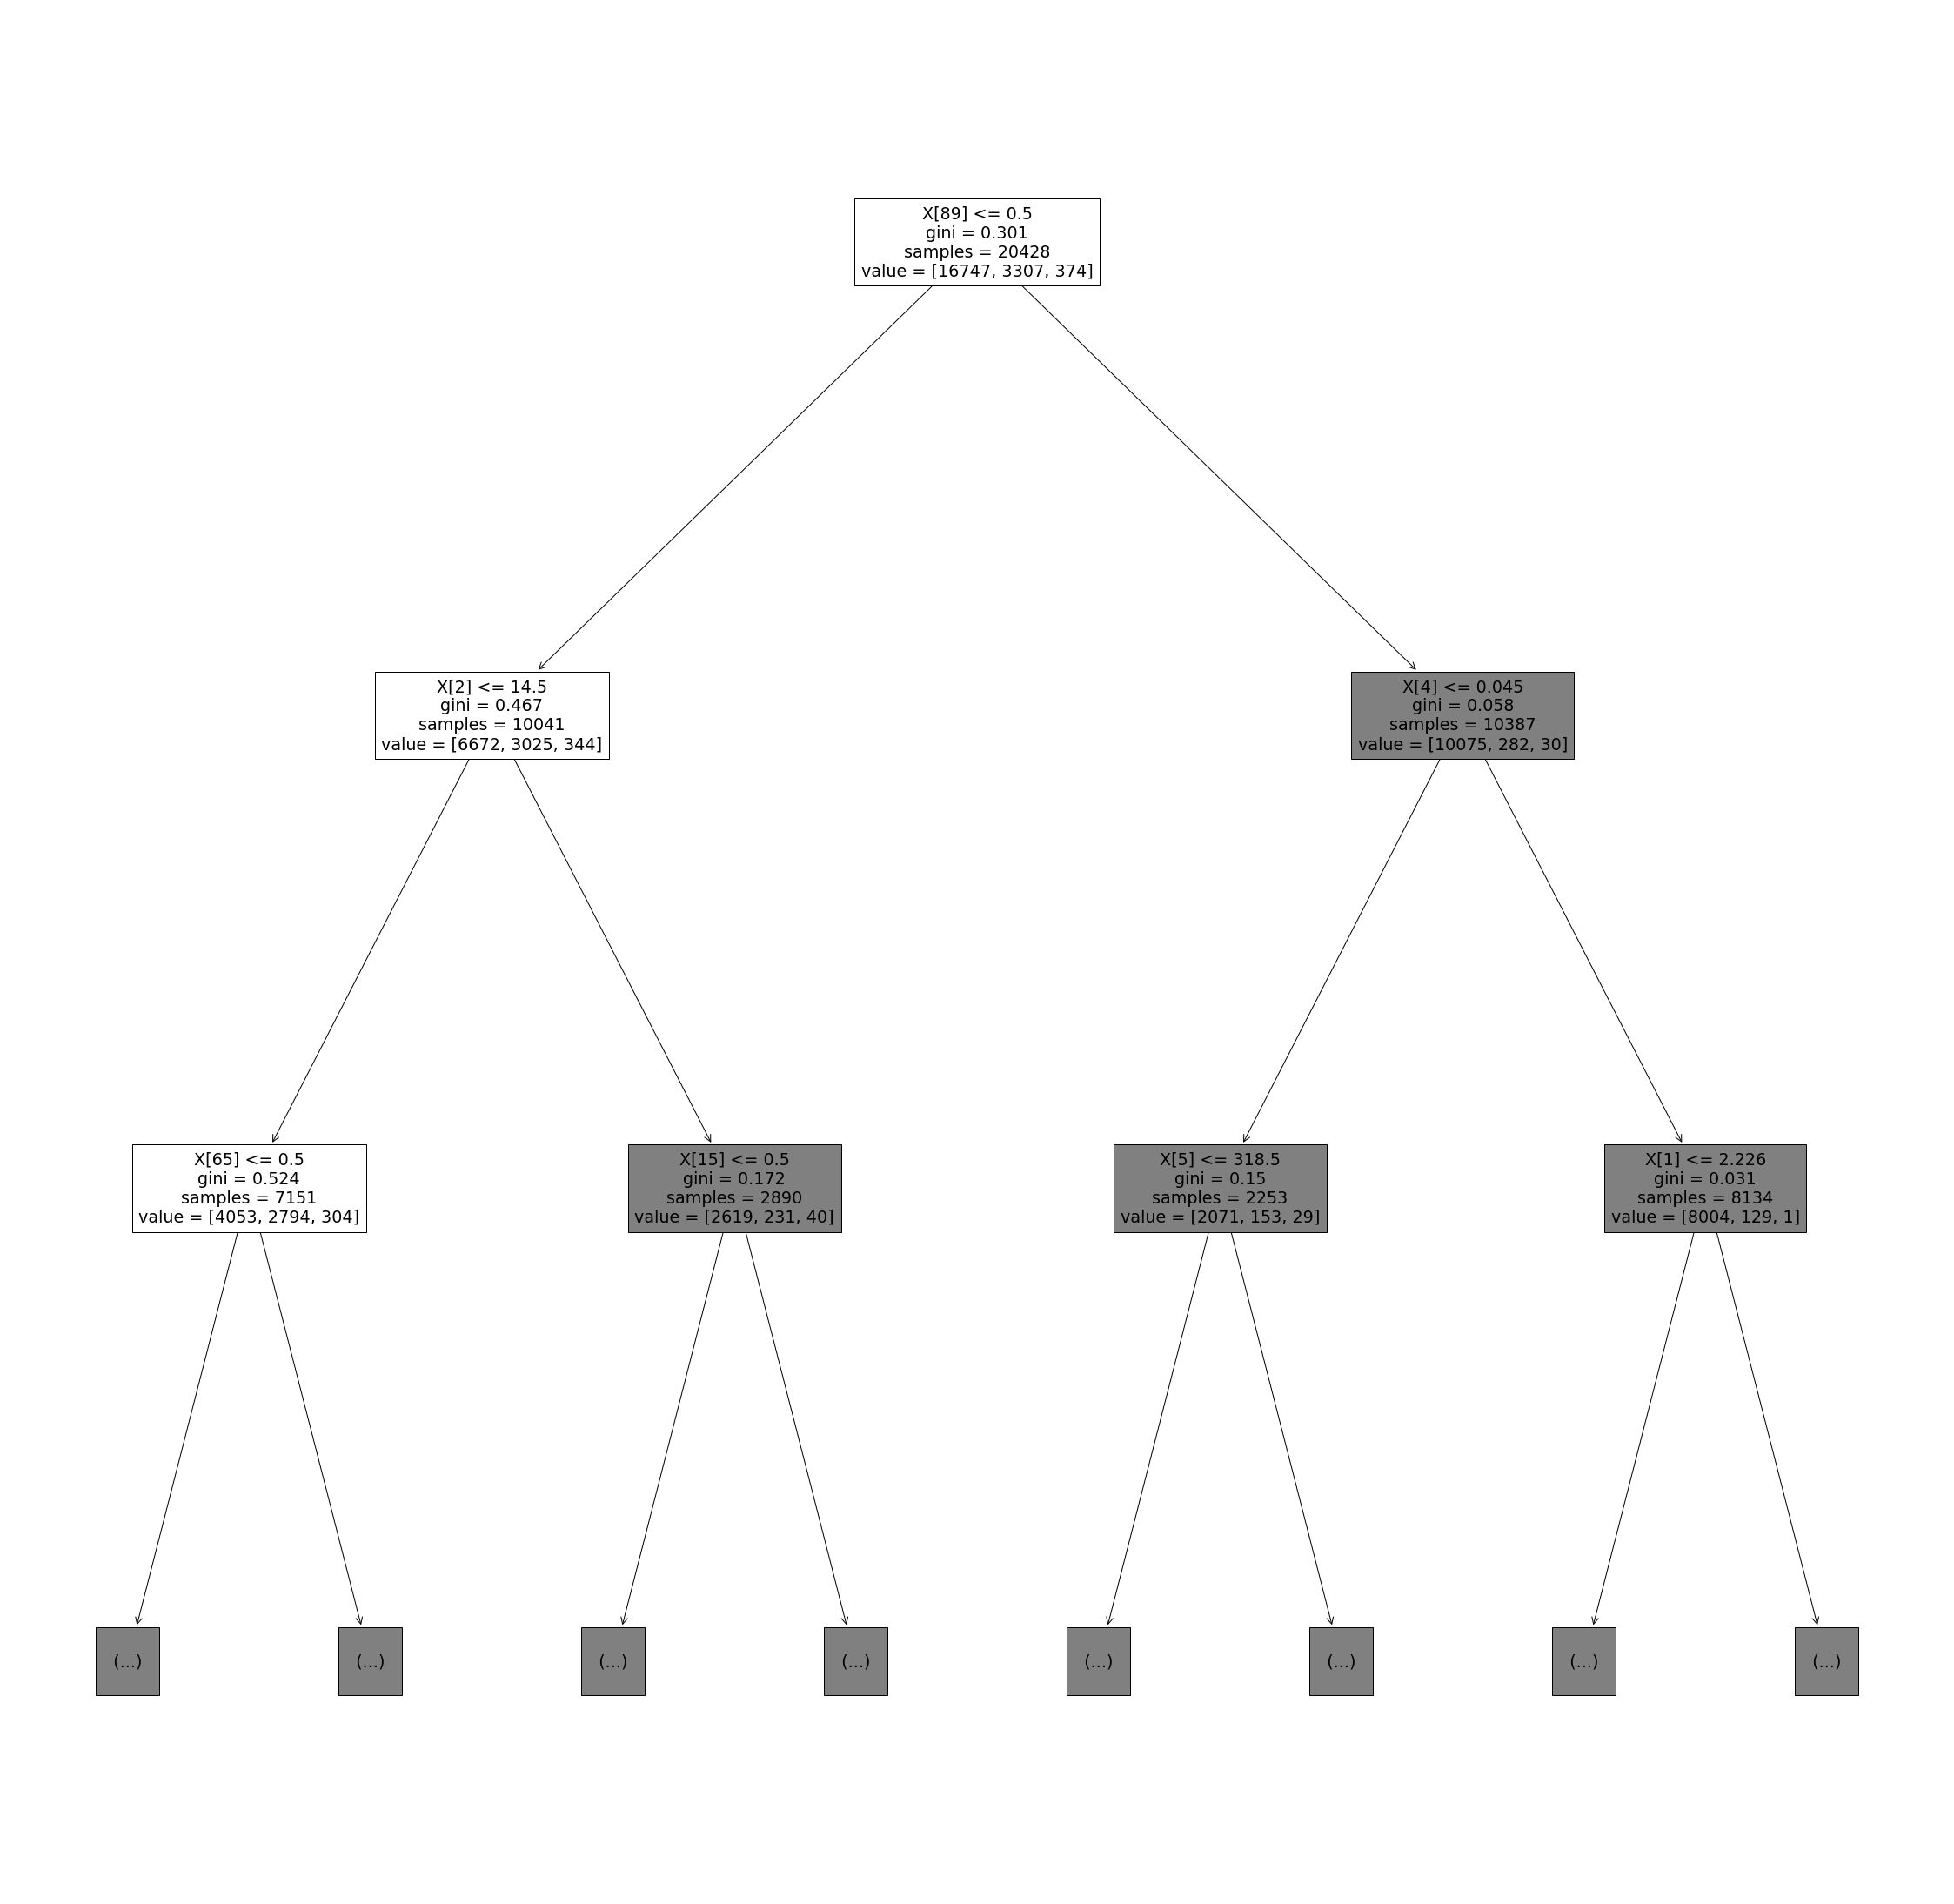

In [24]:
fig=plt.figure(figsize=(40,40))
plot_tree(dt_clf, max_depth = 2)

To know the most important features, we use the "feature\_importances\_" attribute of the decision tree. As stated in the package documentation, the importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.
We make a list that tuples the importance with the position of the feature in the original list.

In [19]:
array = []
for c, feature in enumerate(dt_clf.feature_importances_):
    array.append((feature,c))
print(sorted(array, reverse = True)[:3])

[(0.16556683644833578, 0), (0.15521111944213525, 1), (0.14051980999155092, 89)]


With this we know that the features 0, 1 and 89 are the most important ones. To retrieve the names we just need to ask the dataframe:

In [20]:
print(training_data.columns[[0,1,89]])

Index(['latitude', 'longitude', 'room_type_Private room'], dtype='object')


The most important feature is the location of the apartment, defined by its latitude and longitude. This matches with what we saw in the previous assignment. There are neighbourhoods in Barcelona in which the average price of the apartments is higher than in other neighbourhoods. Those close to the center will usually be more expensive.
Another feature that determines the price category strongly is the "room_type_Private room" or, in other words, if the rented room is private or not. It is common sense that private rooms tend to be pricier than those shared.


**3) Try two Random Forests Classification: one classifying the apartments with the previous
categories as classes of apartments, and a second one where the numerical price is the
classifier feature. Measure the out-of-bag accuracy (you will have to set the
oob_score=True to be able to get within the variable ​ oob\_score\_ ​ the score otherwise is
not computed). Which one works better?**

We will train a classifier and a regressor, each with 500 trees.

In [27]:
rfc = RandomForestClassifier(n_estimators = 500, oob_score=True)
rfc_fit = rfc.fit(training_data, price_categories)
print("%.3f"%(rfc_fit.oob_score_))

0.874


In [28]:
rfr = RandomForestRegressor(n_estimators = 500, oob_score=True)
rfr_fit = rfr.fit(training_data, prices)
print("%.3f"%(rfr_fit.oob_score_))

0.436


The out of bag score is higher in the classifier than in the regressor. That could be because it is easier to correctly predict by chance that an apartment is from a price category than assigning it a specific price value, since the price categories are ranges of values.